# Heatmap
### Read in final tract/code/score combos
### Use the census tract shape files to make a map of SD w/ tract boundaries
### For each code, color code the map and save it as a .jpg

In [1]:
# imports
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd
import shapefile as sf
from pyproj import Proj

%matplotlib inline

In [37]:
# read in dataframe of tracts, codes, and scores
df_scores = pd.read_csv('data_final/tracts_codes_scores.csv',index_col=0)

# test looking up a score given a tract and code
tract = 9104
code = 21
# get correct row of dataframe
score_row = df_scores[(df_scores.census_tract==tract) & (df_scores.code_simple==code)].score
# get score itself
score = score_row.values[0]
print score
print min(df_scores.score)
print max(df_scores.score)

47.1239343231
0.0
99.015673109


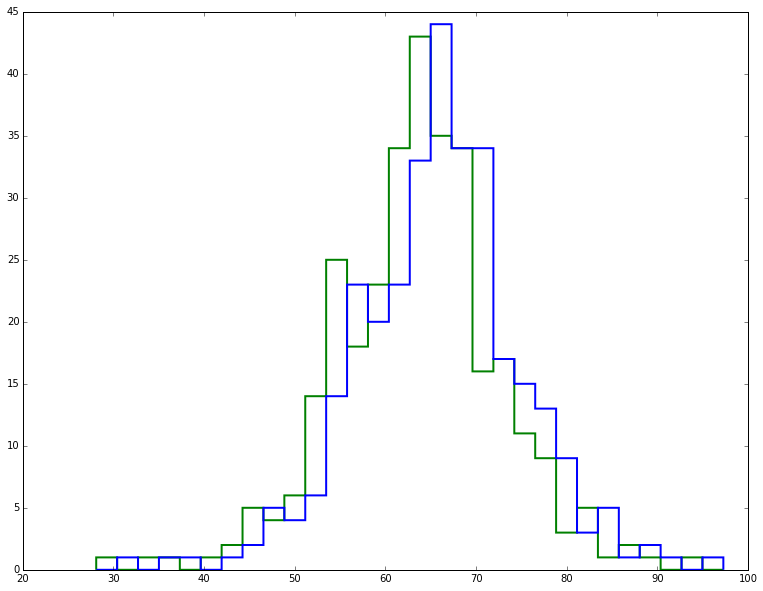

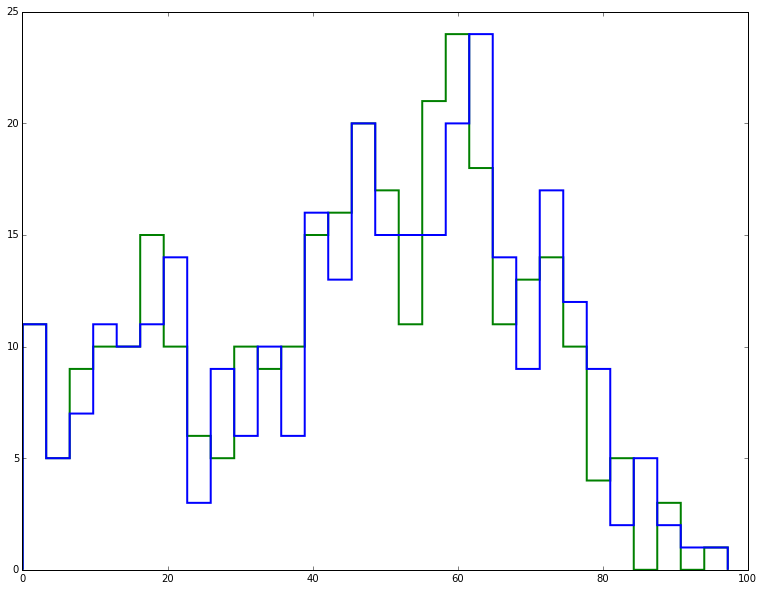

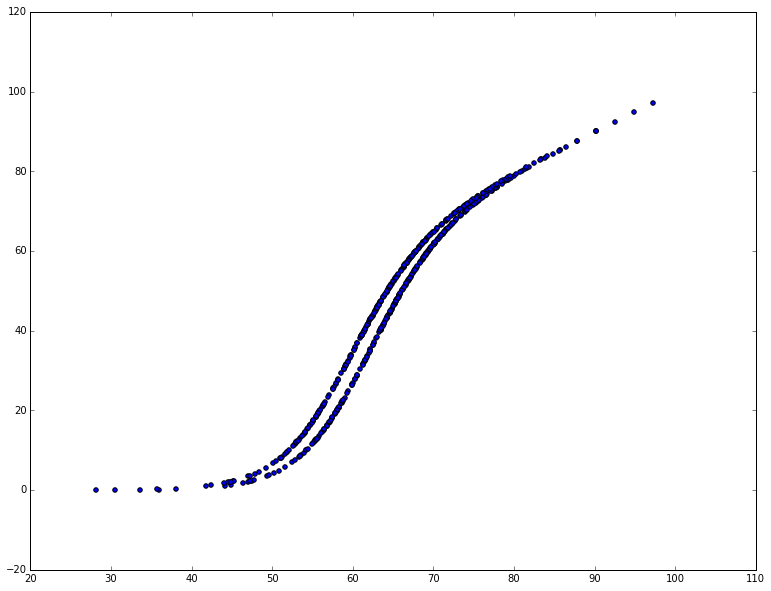

In [52]:
# plot hist of scores for two different codes
plt.figure(figsize=(13, 10))
temp1 = df_scores[df_scores.code_simple==44].score
temp2 = df_scores[df_scores.code_simple==22].score
plt.hist([temp1,temp2], bins=30, histtype='step', align='mid', linewidth=2);

plt.figure(figsize=(13, 10))
t1 = temp1/(1+3/np.std(temp1)*np.exp(-2/np.std(temp1)*(temp1-np.mean(temp1))))
t2 = temp2/(1+3/np.std(temp2)*np.exp(-2/np.std(temp2)*(temp2-np.mean(temp2))))
plt.hist([t1,t2], bins=30, histtype='step', align='mid', linewidth=2);

plt.figure(figsize=(13, 10))
plt.scatter(temp1,t1)
plt.scatter(temp2,t2)

In [53]:
# read in shapefile
mc_reader = sf.Reader('data/CENSUS_TRACTS_2010/CENSUS_TRACTS_2010.shp')
mc_records = pd.DataFrame(mc_reader.records())
mc_shapes = mc_reader.shapes()

# save tracts from shape file
mc_tracts = np.round(mc_records[0].values*100)
print len(mc_records)
print len(mc_shapes)
print len(mc_tracts)

627
627
627


# tracts/patches plotted: 313 for code 11
# tracts/patches plotted: 313 for code 21
# tracts/patches plotted: 313 for code 22


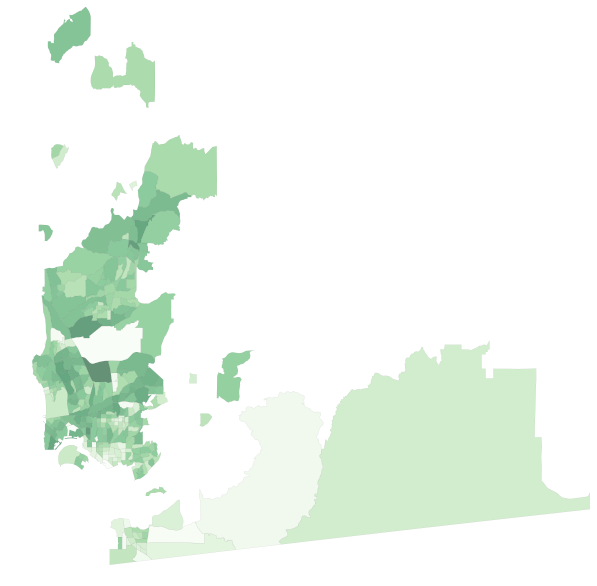

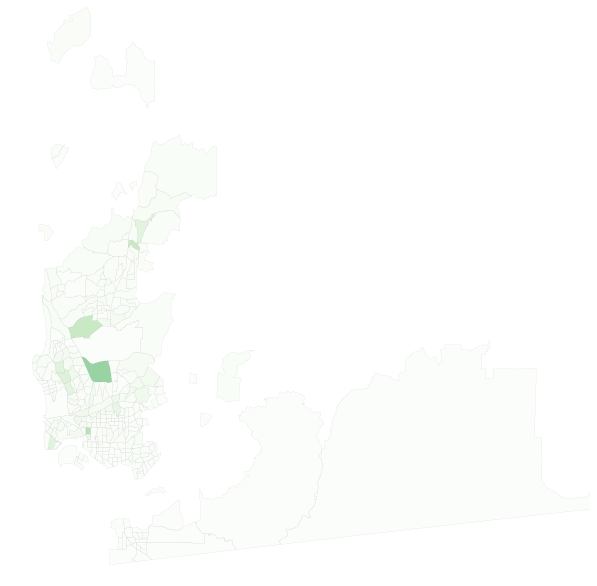

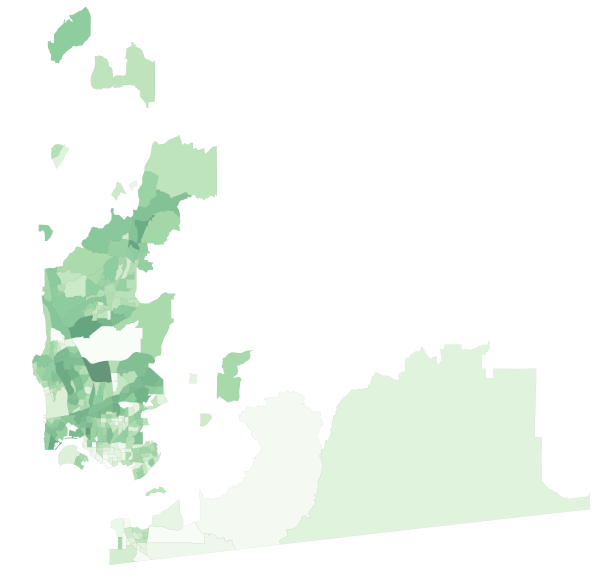

In [56]:
# convert shapefile from XY to lat/lon
p1 = Proj("+init=EPSG:2230", preserve_units=True)


# define list of simple NAICS business codes
codes = [11,21,]#,23,31,32,33,42,44,45,48,49,51,52,53,54,55,56,61,62,71,72,81,92]

# go through each code
for code in codes:

    # plot shapefile outlines
    fig,ax = plt.subplots(1,1, figsize=(10,10))

    # initialize list of patches # of patches
    patches = []
    scores = []
    count = 0

    # go through each shape/tract
    for i in range(0,len(mc_shapes)):
        # if it's a tract that we have a score for
        if mc_tracts[i] in df_scores.census_tract.values:
            # save the points of the shape
            temp = pd.DataFrame(mc_shapes[i].points)
            # convert XY to lon/lat
            lon, lat = p1(np.array(temp.loc[0:33632, 0]), np.array(temp.loc[0:33632, 1]), inverse=True)

            # find score for current tract
            score_row = df_scores[(df_scores.census_tract==mc_tracts[i]) & (df_scores.code_simple==code)].score
            score = score_row.values[0]
            # convolve score with logistic function
            scaled_score = score/(1+3/np.std(df_scores.score)* \
                                  np.exp(-2/np.std(df_scores.score)*(score-np.mean(df_scores.score))))
            scores.append(scaled_score)
        
            # define the polygon for the tract
            poly = plt.Polygon(np.transpose([lon,lat]), fc='none', ec='none', lw=.1, alpha=1.0)
            # save the patch
            patches.append(poly)
        
            # plot the patch/tract
            #plt.gca().add_patch(poly)
        
            # count the tract
            count+=1

    # set up color table
    p = PatchCollection(patches, cmap='Greens', alpha=0.6, lw=0.05, edgecolor='k')
    p.set_array(np.array(scores))
    #p.set_clim([min(scores),max(scores)])
    p.set_clim([min(df_scores.score),max(df_scores.score)])

    # add colors to patches
    ax.add_collection(p)

    # tighten the axis ranges
    ax.axis('tight')
    # turn off axes
    plt.axis('off')
    print '# tracts/patches plotted: '+str(count)+' for code '+str(code)
    plt.savefig('wheresious/static/map_'+str(code), bbox_inches='tight', transparent=True, dpi=800, frameon=False);
#print plt.xlim()
#print plt.ylim()